Trains a GNN using the datasert from MAHOMES II publication and evaluiated it on the test-set

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool

from data import SiteDataset
from torch_geometric.loader import DataLoader

import time 

In [2]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

In [3]:
dataset = SiteDataset("input_data/dataset")
print(dataset)
print(dataset[0])

testset = SiteDataset("input_data/testset")
print(testset)
print(testset[0])

SiteDataset(3738)
Data(x=[351, 7], edge_index=[2, 9274], y=0, pos=[351, 3])
SiteDataset(556)
Data(x=[837, 7], edge_index=[2, 23928], y=0, pos=[837, 3])


In [4]:
b_size =16
train_loader = DataLoader(dataset, shuffle=True, batch_size=b_size)
test_loader =  DataLoader(testset, shuffle=True, batch_size=b_size)

In [5]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(15)
        self.conv1 = GCNConv(7, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)

        self.lin = Linear(hidden_channels, 2, bias=False)

    def forward(self, x, edge_index, batch):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.relu(self.conv3(x, edge_index))
        x = F.dropout(x, p=0.25, training=self.training)
        x = torch.relu(self.conv4(x, edge_index))
        
        x = global_mean_pool(x, batch) 
        x = self.lin(x)
        
        return x

In [6]:
model = GCN(hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)
criterion = torch.nn.CrossEntropyLoss()

def train(train_loader):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    
     # Iterate in batches over the training dataset.
    for data in train_loader: 
         optimizer.zero_grad()
         
         out = model(data.x, data.edge_index, data.batch) 
         loss = criterion(out, data.y)  
         loss.backward()
         optimizer.step() 
         running_loss += loss.item()
    end_time = time.time()
    elapsed_time = end_time - start_time
    average_loss = running_loss / len(train_loader)
    print(f"Training - Elapsed Time: {elapsed_time:.2f}s  Loss: {average_loss:.4f}", end='\t')
    return(end_time, average_loss)

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         #print(out)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         #print(pred)
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

results = []
for epoch in range(1, 101):
    print(f'Epoch: {epoch:03d}', end='\t')
    train_time, train_loss = train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'\tTrain Acc: {train_acc:.4f}\tTest Acc: {test_acc:.4f}')
    results.append([epoch, train_time, train_loss, train_acc, test_acc])

Epoch: 001	Training - Elapsed Time: 135.04s  Loss: 0.6220		Train Acc: 0.6913	Test Acc: 0.6025
Epoch: 002	Training - Elapsed Time: 134.15s  Loss: 0.5191		Train Acc: 0.6913	Test Acc: 0.6025
Epoch: 003	Training - Elapsed Time: 124.15s  Loss: 0.4960		Train Acc: 0.6857	Test Acc: 0.6205
Epoch: 004	Training - Elapsed Time: 132.69s  Loss: 0.4906		Train Acc: 0.6859	Test Acc: 0.6385
Epoch: 005	Training - Elapsed Time: 134.08s  Loss: 0.4834		Train Acc: 0.6993	Test Acc: 0.6637
Epoch: 006	Training - Elapsed Time: 131.64s  Loss: 0.4894		Train Acc: 0.6996	Test Acc: 0.6673
Epoch: 007	Training - Elapsed Time: 133.03s  Loss: 0.4805		Train Acc: 0.7092	Test Acc: 0.6709
Epoch: 008	Training - Elapsed Time: 133.69s  Loss: 0.4801		Train Acc: 0.7138	Test Acc: 0.6924
Epoch: 009	Training - Elapsed Time: 134.44s  Loss: 0.4816		Train Acc: 0.7247	Test Acc: 0.6996
Epoch: 010	Training - Elapsed Time: 131.86s  Loss: 0.4671		Train Acc: 0.7293	Test Acc: 0.7284
Epoch: 011	Training - Elapsed Time: 132.36s  Loss: 0.4561		T

,epoch,time,loss,train acc.,test acc.
0,1,1.695170e+09,0.621974,0.691279,0.602518


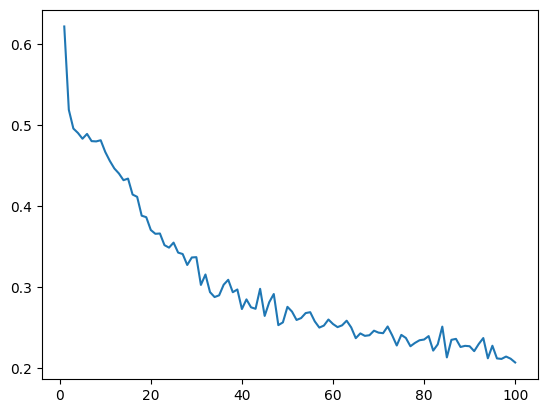

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
results_df = pd.DataFrame(results, columns=['epoch', 'time', 'loss', 'train acc.', 'test acc.'])
display(results_df[:1])

plt.plot(results_df['epoch'], results_df['loss'])

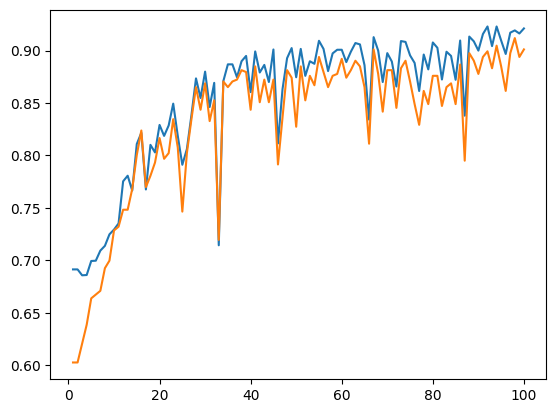

In [8]:
plt.plot(results_df['epoch'], results_df['train acc.'])
plt.plot(results_df['epoch'], results_df['test acc.'])